In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge,RidgeCV, Lasso,LassoCV, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import   ( KFold , StratifiedKFold, cross_val_score, GridSearchCV) 

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from time import time
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("resources/kc_house_data.csv",parse_dates = ['date'])
print(df.isnull().any())
print (df.dtypes)
df.describe()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated             

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [8]:
df_waterfront = pd.get_dummies(df['waterfront']).rename(columns=lambda x:  'y_wf' if x ==1  else 'n_wf')
df=pd.concat([df, df_waterfront], axis=1)
df_zipcode = pd.get_dummies(df['zipcode'])
df.drop(['id', 'date','zipcode','waterfront'], axis = 1, inplace = True)
houseDF=pd.concat([df, df_zipcode], axis=1)

houseDF


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,...,0,0,0,0,0,0,0,0,0,0
5,1225000.0,4,4.50,5420,101930,1.0,0,3,11,3890,...,0,0,0,0,0,0,0,0,0,0
6,257500.0,3,2.25,1715,6819,2.0,0,3,7,1715,...,0,0,0,0,0,0,0,0,0,0
7,291850.0,3,1.50,1060,9711,1.0,0,3,7,1060,...,0,0,0,0,0,0,0,0,1,0
8,229500.0,3,1.00,1780,7470,1.0,0,3,7,1050,...,1,0,0,0,0,0,0,0,0,0
9,323000.0,3,2.50,1890,6560,2.0,0,3,7,1890,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y = houseDF.price.values
houseDF.drop(['price'], axis = 1, inplace = True)
X=houseDF.as_matrix()

columns=houseDF.columns.values.tolist()
rfReg = RandomForestRegressor()
rfReg.fit(X, y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rfReg.feature_importances_), columns),
             reverse=True))

Features sorted by their score:
[(0.3206, 'grade'), (0.26690000000000003, 'sqft_living'), (0.1646, 'lat'), (0.073400000000000007, 'long'), (0.0275, 'sqft_living15'), (0.022200000000000001, 'yr_built'), (0.017500000000000002, 'y_wf'), (0.015299999999999999, 'sqft_above'), (0.014500000000000001, 'sqft_lot'), (0.013599999999999999, 'sqft_lot15'), (0.012699999999999999, 'n_wf'), (0.0095999999999999992, 'view'), (0.0086999999999999994, 'bathrooms'), (0.0054000000000000003, 98004), (0.0048999999999999998, 'sqft_basement'), (0.0030000000000000001, 'bedrooms'), (0.0025000000000000001, 'condition'), (0.0023999999999999998, 98039), (0.002, 98040), (0.0018, 'yr_renovated'), (0.0015, 'floors'), (0.0011000000000000001, 98112), (0.00080000000000000004, 98144), (0.00069999999999999999, 98119), (0.00069999999999999999, 98109), (0.00050000000000000001, 98006), (0.00040000000000000002, 98033), (0.00029999999999999997, 98107), (0.00029999999999999997, 98034), (0.00020000000000000001, 98177), (0.000200000

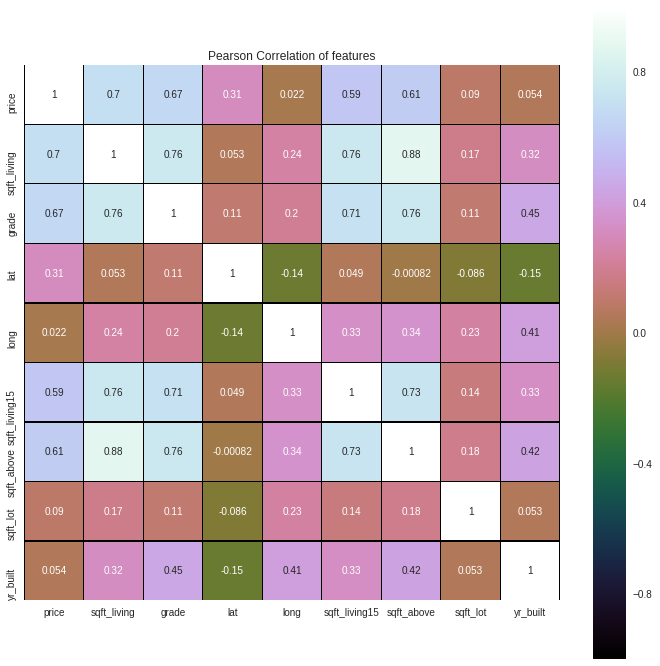

In [10]:
plt.subplots(figsize=(12, 12))
plt.title('Pearson Correlation of features')
dfHeatPlot = df[['price', 'sqft_living', 'grade', 'lat', 'long', 'sqft_living15', 'sqft_above', 'sqft_lot', 'yr_built']]
sns.heatmap(dfHeatPlot.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True, cmap="cubehelix", linecolor='k',
            annot=True)

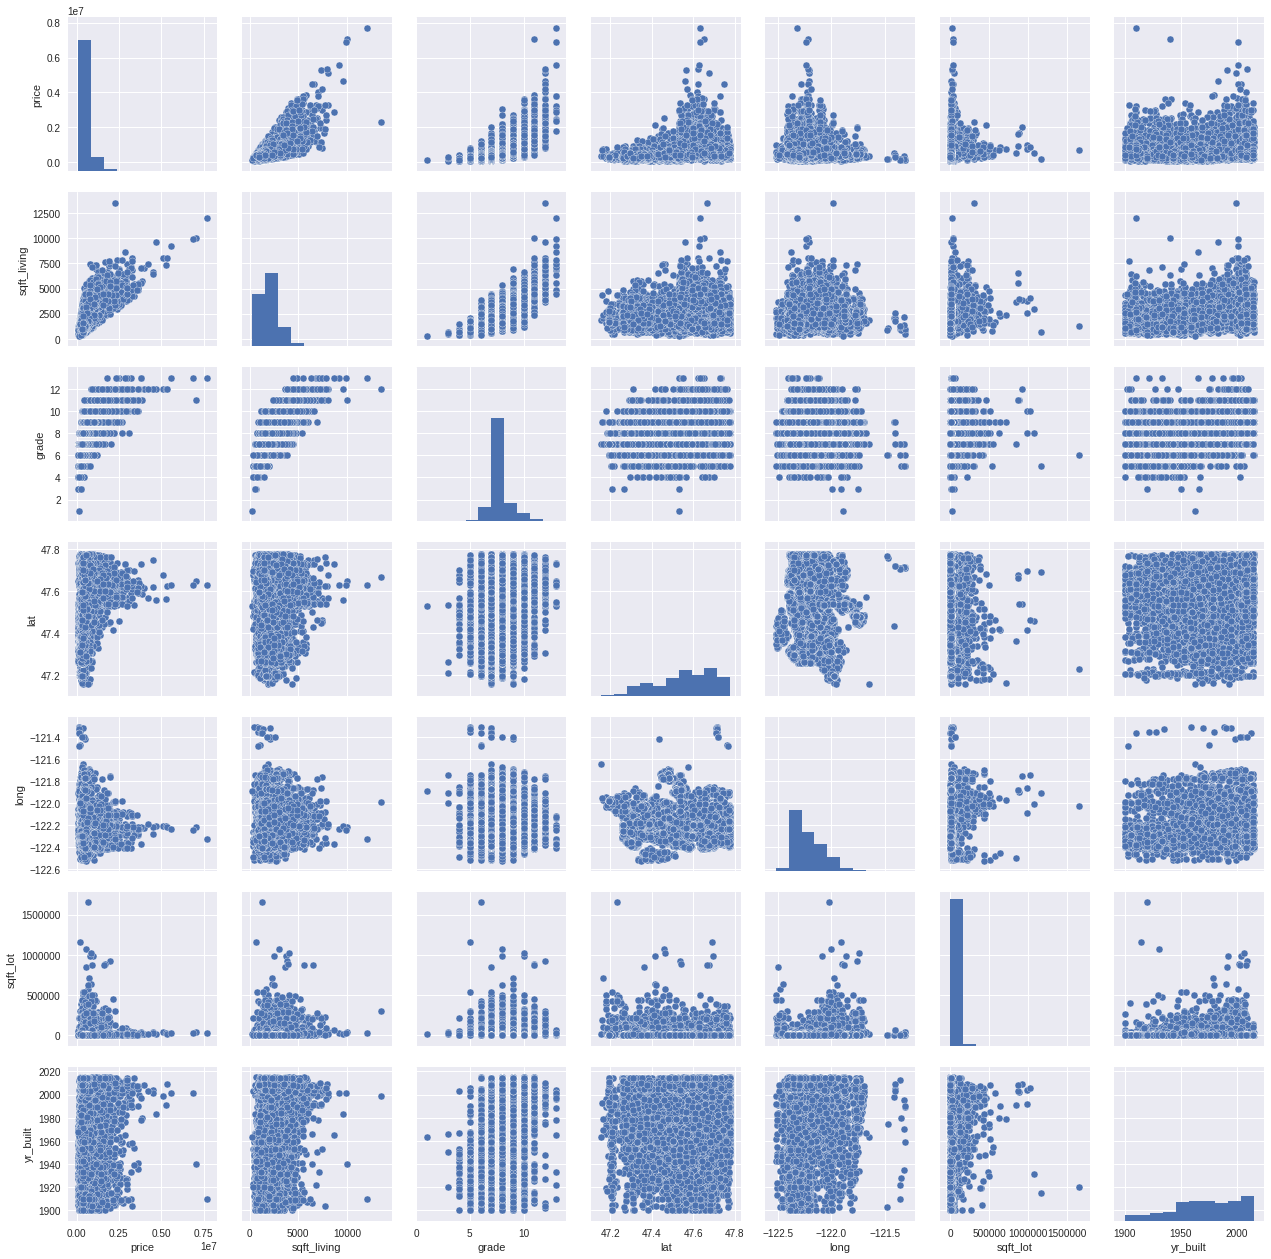

In [11]:
dfPairPlot = df[['price', 'sqft_living', 'grade', 'lat', 'long',  'sqft_lot', 'yr_built']]

plt.figure(figsize=(8,8))
sns.pairplot(dfPairPlot,palette='coolwarm')
plt.show()

In [12]:


dfModel = df[['price', 'grade', 'sqft_living', 'lat', 'long', 'sqft_living15', 
           'yr_built','sqft_above', 'n_wf', 'y_wf' , 'sqft_lot15' ,'sqft_lot', 'view','sqft_lot15','y_wf']]
 

y_train = dfModel.price.values
dfModel.drop(['price'], axis = 1, inplace = True)
X_train=dfModel.as_matrix()
alphas = np.logspace(-5, 5, 50)
alphas_r = np.logspace(-10, 10, 100)

pipelines = []
seed = 7
#The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum()
#and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum().
#Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
#A constant model that always predicts the expected value of y, disregarding the input features,
#would get a R^2 score of 0.0.
score_method = 'r2'
cv_results, names, times  = [], [] , []
num_folds = 10

pipelines.append( ('lassoCV',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('lassoCV', LassoCV(alphas=alphas, random_state=0, normalize=True))]) ) )
pipelines.append( ('RidgeCV',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('RidgeCV', RidgeCV(alphas=alphas_r,  normalize=True))]) ) )
pipelines.append( ('LinearRegression',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('LinearRegression', LinearRegression( normalize=True))]) ) )
pipelines.append( ('RandomForestRegressor',
                   Pipeline([
                              ('sc', StandardScaler()),
                             ('RandomForestRegressor', RandomForestRegressor())]) ) )
    




for name, estimator in pipelines:
    start = time()
    kfold = KFold(n_splits=num_folds, random_state=seed)
    crossValScore = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring = score_method,
                                n_jobs=-1) 
    timeSpent = time() - start
    cv_results.append(crossValScore)
    names.append(name)
    times.append(timeSpent)
    message = "%s: %f (+/- %f) completed in %f seconds" % (name, crossValScore.mean(), 
                                                       crossValScore.std(), timeSpent)
    print(message)

lassoCV: 0.682073 (+/- 0.012089) completed in 2.100989 seconds
RidgeCV: 0.682073 (+/- 0.012104) completed in 3.603332 seconds
LinearRegression: 0.682085 (+/- 0.012098) completed in 0.398392 seconds
RandomForestRegressor: 0.865291 (+/- 0.019366) completed in 3.199562 seconds


In [22]:
estimtor =RandomForestRegressor()
print (estimator.get_params().keys())

dict_keys(['steps', 'sc', 'RandomForestRegressor', 'sc__copy', 'sc__with_mean', 'sc__with_std', 'RandomForestRegressor__bootstrap', 'RandomForestRegressor__criterion', 'RandomForestRegressor__max_depth', 'RandomForestRegressor__max_features', 'RandomForestRegressor__max_leaf_nodes', 'RandomForestRegressor__min_impurity_split', 'RandomForestRegressor__min_samples_leaf', 'RandomForestRegressor__min_samples_split', 'RandomForestRegressor__min_weight_fraction_leaf', 'RandomForestRegressor__n_estimators', 'RandomForestRegressor__n_jobs', 'RandomForestRegressor__oob_score', 'RandomForestRegressor__random_state', 'RandomForestRegressor__verbose', 'RandomForestRegressor__warm_start'])


In [36]:
pipeline_randomforestregressor = Pipeline([ 
                      ('sc', StandardScaler()), 
                    ('RandomForestRegressor', RandomForestRegressor(random_state=seed, n_jobs=-1) )])

param_grid_randomforestregressor =  [ {
    'RandomForestRegressor__n_estimators': [ 200,300,400] # set of estimators
  
    }]
 

kfold = StratifiedKFold(n_splits=num_folds, random_state= seed)
grid_randomforestregressor = GridSearchCV(pipeline_randomforestregressor, param_grid_randomforestregressor, cv=kfold,scoring = score_method, 
                   n_jobs=-1, verbose=1)

start = time()
grid_randomforestregressor = grid_randomforestregressor.fit(X, y)
end = time()

print("RandomForestRegressor grid search took %.3f seconds" %(end-start))

# Print best tuning parameters
print('Best Accuracy')
print(grid_randomforestregressor.best_score_ )
print('Best tuning parameters')
print(grid_randomforestregressor.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.2min finished


RandomForestRegressor grid search took 383.624 seconds
Best Accuracy
0.860285277141
Best tuning parameters
{'RandomForestRegressor__n_estimators': 200}
